<a href="https://colab.research.google.com/github/lingmHVAC/lingmHVAC/blob/main/10_15_min_2PTQMOMBase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


CALIBRATED PARAMETERS (two-interval)
Window 0-150: J1=17.012 #/cm3/s, C1=0.000138 µm/s
Window 150-300: J2=16.364 #/cm3/s, C2=0.000193 µm/s
K multiplier=1.000e+03 (Brownian kernel scale)
beta = 1.01e-04 s^-1 µm^-2


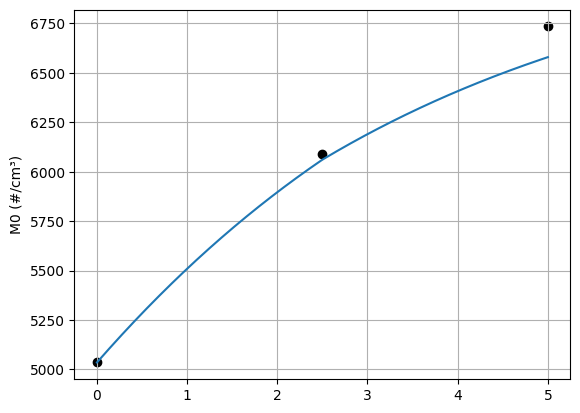

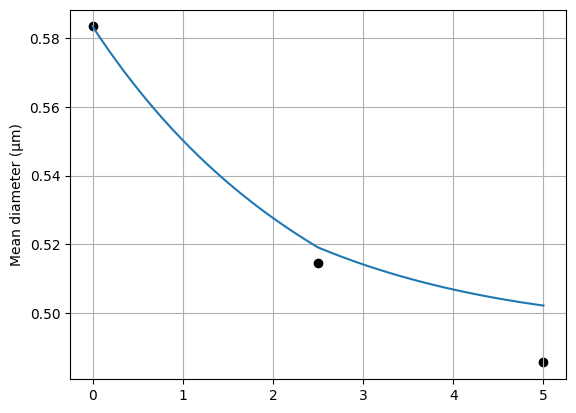

In [2]:
# All models with physical sedimentation
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
# last modified January 11, 2026
# I changed the weights and the effective sedimentation height
# which significantly improved the predictions.
# This code splits an experimental interval 0-300 seconds for
# which we have expt M0-M3 into two intervals 0-150 sec and
# 150s- 300 sec. It seeks to find the J1, C1, J2, C2, K
# that best satisfy the expt moments at 0, 150, and 300 sec.
# J is the nucleation flux, C is the surface growth, and K is
# the Brownian agglomeration factor.
# In this model, the surface growth is independent of the diameter
#    dM0 = nuc0 + gr0 + co0 + sed0
#    dM1 = nuc1 + gr1 + co1 + sed1
#    dM2 = nuc2 + gr2 + co2 + sed2
#    dM3 = nuc3 + gr3 + co3 + sed3
# I use a weight factor array to help weight the matching to
# particular moments.
# weight vector for [M0, M1, M2, M3]. I get pretty good results
# with  w = np.array([3.0, 2.0, .1, 2.0])
# ============================================================
# SYSTEM GEOMETRY & PHYSICS
# ============================================================
rho_p = 1000      # kg/m3
rho_g = 1.2       # kg/m3
mu = 1.8e-5       # Pa s
g = 9.81          # m/s2
H = .3          # m  <-- effective chamber height

beta = (rho_p - rho_g) * g / (18 * mu * H)
beta *= 1e-12     # convert to s^-1 µm^-2

# ============================================================
# APS MEASUREMENTS
# ============================================================
t_data = np.array([0, 150, 300])
#The data below is 5.7 min to 10.033 min
#M_data = np.array([
#    [5344, 3883, 5575, 21578],
#    [4983, 3347, 4061, 13608],
#    [5035, 2937, 2860, 8382]
#])

#The data below is 10.033 min, 12.533 ,15.033 min
M_data = np.array([
    [5035, 2937, 2860, 8382],
    [6091.68, 3135.418, 2553.06, 7743.80],
    [6734.9, 3270.82, 2438.96, 8130.70]
])

din = 0.3  # µm

# ============================================================
# QMOM (2-node)
# ============================================================
#def qmom_nodes(M):
#    M0, M1, M2, M3 = M
#    mu_d = M1 / M0
#    var = max(M2 / M0 - mu_d**2, 1e-12)
#    std = np.sqrt(var)
#    return 0.5*M0, mu_d - std, 0.5*M0, mu_d + std

def qmom_nodes(M, eps_var=1e-18, Dmin=1e-30):
    """
    Two-node QMOM (Gaussian quadrature) reconstruction from moments M0..M3.

    Returns: (w1, D1, w2, D2) such that
        M_k ≈ w1*D1**k + w2*D2**k for k=0..3

    Notes:
      - Requires M0>0 and realizable moments; if variance is tiny, returns a
        degenerate 1-node quadrature: w1=M0, D1=mu1, w2=0, D2=mu1.
      - Clamps diameters to Dmin to avoid negative/zero nodes.
    """
    M0, M1, M2, M3 = M
    if M0 <= 0.0:
        return 0.0, Dmin, 0.0, Dmin

    # normalized moments
    mu1 = M1 / M0
    mu2 = M2 / M0
    mu3 = M3 / M0

    # variance-like term
    b1 = mu2 - mu1**2
    if b1 <= eps_var:
        D = max(mu1, Dmin)
        return float(M0), float(D), 0.0, float(D)

    a0 = mu1
    a1 = (mu3 - 2.0*mu1*mu2 + mu1**3) / b1

    # Solve for eigenvalues of 2x2 Jacobi matrix:
    # x^2 - (a0+a1)x + (a0*a1 - b1) = 0
    trace = a0 + a1
    det = a0*a1 - b1
    disc = trace*trace - 4.0*det
    disc = max(disc, 0.0)
    sqrt_disc = np.sqrt(disc)

    D1 = 0.5*(trace - sqrt_disc)
    D2 = 0.5*(trace + sqrt_disc)

    # enforce ordering and positivity
    D1 = max(D1, Dmin)
    D2 = max(D2, D1*(1.0 + 1e-12))

    # weights from M0 and M1
    # w1 + w2 = M0
    # w1*D1 + w2*D2 = M1
    denom = (D2 - D1)
    w1 = M0 * (D2 - mu1) / denom
    w2 = M0 * (mu1 - D1) / denom

    # small numerical cleanup
    if w1 < 0 and abs(w1) < 1e-12:
        w1 = 0.0
    if w2 < 0 and abs(w2) < 1e-12:
        w2 = 0.0

    return float(w1), float(D1), float(w2), float(D2)


# ============================================================
# MOMENT ODEs
# ============================================================
#def coag_source_qmom(k, K, w1, d1, w2, d2):
#    Ds = np.array([d1, d2], dtype=float)
#    Ws = np.array([w1, w2], dtype=float)
#    s = 0.0
#    for i in range(2):
#        for j in range(2):
#            di, dj = Ds[i], Ds[j]
#            wi, wj = Ws[i], Ws[j]
#            dp = np.cbrt(di**3 + dj**3)   # robust real cube root
#            s += (dp**k - di**k - dj**k) * wi * wj
#    return 0.5 * K * s

kB = 1.380649e-23  # J/K


# K_brownian_continuum_cm3s(di_um, dj_um, T=298.0, mu_g=1.8e-5):
def K_brownian_continuum(di, dj, T=298.0, mu_g=1.8e-5):
    di = max(di, 1e-30)
    dj = max(dj, 1e-30)
    return 1e6*(2.0 * kB * T / (3.0 * mu_g)) * ( (1.0/di + 1.0/dj) * (di + dj) )

#K=Kmult
def coag_source_qmom(k, K, w1, d1, w2, d2):
    T=298.0
    mu_g=1.8e-5
    Ds = np.array([d1, d2], dtype=float)
    Ws = np.array([w1, w2], dtype=float)
    s = 0.0
    for i in range(2):
        for j in range(2):
            di, dj = Ds[i], Ds[j]
            wi, wj = Ws[i], Ws[j]
            Kij = K * K_brownian_continuum(di, dj, T=T, mu_g=mu_g)
            dp = np.cbrt(di**3 + dj**3)
            s += Kij * (dp**k - di**k - dj**k) * wi * wj
    return 0.5 * s

#def moment_rhs(t, y, Jin, Cg, K):
#    M0, M1, M2, M3 = y
#    M0 = max(M0, 1e-9)
#
#    w1, d1, w2, d2 = qmom_nodes(y)
#    M4 = w1*d1**4 + w2*d2**4
#    M5 = w1*d1**5 + w2*d2**5
#
#    dM0 = Jin - 0.5*K*M0**2 - beta*M2
#    dM1 = Jin*din + Cg*M0 - beta*M3
#    dM2 = Jin*din**2 + 2*Cg*M1 + K*M1**2 - beta*M4
#    dM3 = Jin*din**3 + 3*Cg*M2 + 3*K*M1*M2 - beta*M5
#
#    return [dM0, dM1, dM2, dM3]

def moment_rhs(t, y, Jin, Cg, K):
    M0, M1, M2, M3 = y
    M0 = max(M0, 1e-12)

    w1, d1, w2, d2 = qmom_nodes(y)

    # higher moments for sedimentation sink
    M4 = w1*d1**4 + w2*d2**4
    M5 = w1*d1**5 + w2*d2**5

    # --- nucleation contributions ---
    nuc0 = Jin
    nuc1 = Jin * din
    nuc2 = Jin * din**2
    nuc3 = Jin * din**3

    # --- growth contributions (this assumes G_d is constant = Cg) ---
    # If your growth is actually m=-1 etc, change these accordingly.
    gr0 = 0.0
    gr1 = Cg * M0
    gr2 = 2.0 * Cg * M1
    gr3 = 3.0 * Cg * M2

    # --- coagulation contributions via QMOM closure ---
    co0 = coag_source_qmom(0, K, w1, d1, w2, d2)
    co1 = coag_source_qmom(1, K, w1, d1, w2, d2)
    co2 = coag_source_qmom(2, K, w1, d1, w2, d2)
    co3 = coag_source_qmom(3, K, w1, d1, w2, d2)

    # --- sedimentation sinks ---
    sed0 = -beta * M2
    sed1 = -beta * M3
    sed2 = -beta * M4
    sed3 = -beta * M5

    dM0 = nuc0 + gr0 + co0 + sed0
    dM1 = nuc1 + gr1 + co1 + sed1
    dM2 = nuc2 + gr2 + co2 + sed2
    dM3 = nuc3 + gr3 + co3 + sed3

    return [dM0, dM1, dM2, dM3]

def integrate_window(t0, t1, y0, Jin, Cg, K):
    sol = solve_ivp(
        lambda t, y: moment_rhs(t, y, Jin, Cg, K),
        (t0, t1),
        y0,
        t_eval=[t1],        # only need the endpoint
        method="BDF",
        rtol=1e-8,
        atol=1e-10
    )
    if (not sol.success) or np.any(~np.isfinite(sol.y)):
        return None
    return sol.y[:, -1]     # state at t1


def rel_residual(model, data):
    denom = np.maximum(np.abs(data), 1.0)
    return (model - data) / denom

def integrate_endpoint(t0, t1, y0, Jin, Cg, K):
    """
    Integrate moment ODEs from t0 to t1 and return the state at t1.
    Used for two-interval calibration.
    """
    sol = solve_ivp(
        lambda t, y: moment_rhs(t, y, Jin, Cg, K),
        (t0, t1),
        y0,
        t_eval=[t1],          # only need endpoint
        method="BDF",         # stiff-safe
        rtol=1e-8,
        atol=1e-10
    )

    if (not sol.success) or np.any(~np.isfinite(sol.y)):
        return None

    return sol.y[:, -1]      # shape (4,)


def residuals_two_interval(params):
    J1, C1, J2, C2, K = params

    y150_model = integrate_endpoint(0.0, 150.0, M_data[0], J1, C1, K)
    if y150_model is None:
        return 1e6*np.ones(8)

    y300_model = integrate_endpoint(150.0, 300.0, y150_model, J2, C2, K)
    if y300_model is None:
        return 1e6*np.ones(8)

    y150_data = M_data[1]
    y300_data = M_data[2]

    r150 = (y150_model - y150_data) / np.maximum(np.abs(y150_data), 1.0)
    r300 = (y300_model - y300_data) / np.maximum(np.abs(y300_data), 1.0)

    # weight vector for [M0, M1, M2, M3]
    #w = np.array([3.0, 2.0, .1, 2.0])
    w = np.array([1.0, 1.0, 60., 1.0])

    r150 *= w
    r300 *= w

    return np.hstack([r150, r300])


# def residuals_two_interval(params):
#     J1, C1, J2, C2, K = params

#     y0 = M_data[0]               # state at t=0
#     y150_target = M_data[1]      # data at t=150
#     y300_target = M_data[2]      # data at t=300

#     # integrate 0 -> 150 using window 1 params
#     y150_model = integrate_window(0.0, 150.0, y0, J1, C1, K)
#     if y150_model is None:
#         return 1e6 * np.ones(8)  # 4 moments at 150 + 4 moments at 300

#     # integrate 150 -> 300 using window 2 params, starting from model state at 150
#     y300_model = integrate_window(150.0, 300.0, y150_model, J2, C2, K)
#     if y300_model is None:
#         return 1e6 * np.ones(8)

#     r150 = rel_residual(y150_model, y150_target)
#     r300 = rel_residual(y300_model, y300_target)

#     return np.hstack([r150, r300])

# ============================================================
# CALIBRATION
# ============================================================
#def residuals(params):
#    Jin, Cg, K = params
#    sol = solve_ivp(
#        lambda t, y: moment_rhs(t, y, Jin, Cg, K),
#        [0, 300],
#        M_data[0],
#        t_eval=t_data
#    )
#    return (sol.y.T - M_data).ravel()
#def residuals(params):
#    Jin, Cg, K = params

#    sol = solve_ivp(
    #     lambda t, y: moment_rhs(t, y, Jin, Cg, K),
    #     (t_data[0], t_data[-1]),
    #     M_data[0],
    #     t_eval=t_data,
    #     method="BDF",        # better if stiff
    #     rtol=1e-8,
    #     atol=1e-10
    # )

    # if (not sol.success) or np.any(~np.isfinite(sol.y)):
    #     # punish failed integrations so optimizer moves away
    #     return 1e6 * np.ones(M_data.size)

    # model = sol.y.T

    # # Relative residuals (recommended)
    # denom = np.maximum(np.abs(M_data), 1.0)
    # r = (model - M_data) / denom
    # return r.ravel()

x0 = [10, 0.004,   10, 0.004,   1.0]      # [J1,C1,J2,C2,K]
lb = [0,  0.0,     0,  0.0,     0.0]
ub = [50, 0.02,    50, 0.02,    1e3]      # K is a multiplier in your Brownian kernel

res = least_squares(
    residuals_two_interval,
    x0,
    bounds=(lb, ub)
)

J1, C1, J2, C2, K = res.x

print("\nCALIBRATED PARAMETERS (two-interval)")
print(f"Window 0-150: J1={J1:.3f} #/cm3/s, C1={C1:.6f} µm/s")
print(f"Window 150-300: J2={J2:.3f} #/cm3/s, C2={C2:.6f} µm/s")
print(f"K multiplier={K:.3e} (Brownian kernel scale)")
print(f"beta = {beta:.2e} s^-1 µm^-2")


# res = least_squares(
#     residuals,
#     [10, 0.004, 1e-10],
#     bounds=([0, 0, 0], [50, 0.02, 1e-8])
# )

# Jin, Cg, K = res.x

# print("\nCALIBRATED PARAMETERS")
# print(f"J_in = {Jin:.2f} #/cm3/s")
# print(f"C_g  = {Cg:.4f} µm/s")
# print(f"K    = {K:.2e} cm3/s")
# print(f"beta = {beta:.2e} s^-1 µm^-2 (from H)")

# ============================================================
# FULL SOLUTION
# ============================================================
# t = np.linspace(0, 5*60, 400)
# sol = solve_ivp(
#     lambda t, y: moment_rhs(t, y, Jin, Cg, K),
#     [0, 300],
#     M_data[0],
#     t_eval=t
# )

# M0, M1, M2, M3 = sol.y
# mean_d = M1 / M0
t1 = np.linspace(0, 150, 200)
sol1 = solve_ivp(
    lambda t, y: moment_rhs(t, y, J1, C1, K),
    (0, 150),
    M_data[0],
    t_eval=t1,
    method="BDF",
    rtol=1e-8,
    atol=1e-10
)
y150_model = sol1.y[:, -1]

t2 = np.linspace(150, 300, 200)
sol2 = solve_ivp(
    lambda t, y: moment_rhs(t, y, J2, C2, K),
    (150, 300),
    y150_model,
    t_eval=t2,
    method="BDF",
    rtol=1e-8,
    atol=1e-10
)

# stitch
t = np.hstack([sol1.t, sol2.t])
Y = np.hstack([sol1.y, sol2.y])
M0, M1, M2, M3 = Y
mean_d = M1 / M0

# # Mode estimate
# mode = np.zeros_like(mean_d)
# for i in range(len(t)):
#     w1, d1, w2, d2 = qmom_nodes([M0[i], M1[i], M2[i], M3[i]])
#     mode[i] = d1 if w1 > w2 else d2

# # ============================================================
# # PLOTS
# # ============================================================
# plt.figure()
# plt.plot(t/60, M0)
# plt.scatter(t_data/60, M_data[:,0], c='k')
# plt.ylabel("Number (#/cm³)")
# plt.xlabel("Time (min)")
# plt.grid()

# plt.figure()
# plt.plot(t/60, M0)
# plt.scatter(t_data/60, M_data[:,2], c='k')
# plt.ylabel("M2")
# plt.xlabel("Time (min)")
# plt.grid()

# plt.figure()
# plt.plot(t/60, M0)
# plt.scatter(t_data/60, M_data[:,3], c='k')
# plt.ylabel("M3")
# plt.xlabel("Time (min)")
# plt.grid()

# plt.figure()
# plt.plot(t/60, mean_d, label="Mean")
# #plt.plot(t/60, mode, '--', label="Mode")
# plt.scatter(t_data/60, M_data[:,1]/M_data[:,0], c='k')
# plt.ylabel("Diameter (µm)")
# plt.xlabel("Time (min)")
# plt.legend()
# plt.grid()
# plt.show()
plt.figure()
plt.plot(t/60, M0)
plt.scatter(t_data/60, M_data[:,0], c='k')
plt.ylabel("M0 (#/cm³)")
plt.grid()

plt.figure()
plt.plot(t/60, mean_d)
plt.scatter(t_data/60, M_data[:,1]/M_data[:,0], c='k')
plt.ylabel("Mean diameter (µm)")
plt.grid()
plt.show()

#np.savetxt('data.csv', (t/60, M0, mean_d), delimiter=',')


# Task
## Mathematical Formulation of Moment Dynamics

This document details the mathematical equations underpinning the aerosol dynamics model, specifically focusing on the time evolution of particle moments using the Quadrature Method of Moments (QMOM).

---

## 1. Physical Parameters and Sedimentation Coefficient

The model incorporates several physical parameters that define the system's environment and particle properties:
*   **Particle density**: $\rho_p = 1000 \text{ kg/m}^3$
*   **Gas density**: $\rho_g = 1.2 \text{ kg/m}^3$
*   **Gas viscosity**: $\mu = 1.8 \times 10^{-5} \text{ Pa s}$
*   **Acceleration due to gravity**: $g = 9.81 \text{ m/s}^2$
*   **Effective chamber height**: $H = 0.3 \text{ m}$

These parameters are crucial for calculating the sedimentation coefficient, $\beta$, which quantifies the rate at which particles are removed from the system due to gravitational settling. The formula for $\beta$ is derived from Stokes' law for sedimentation velocity and is given by:

$$ \beta = \frac{(\rho_p - \rho_g) g}{18 \mu H} $$

In the computational implementation, $\beta$ is subsequently scaled by $1 \times 10^{-12}$ to convert its units to $\text{s}^{-1} \mu \text{m}^{-2}$, ensuring consistency with the diameter units used throughout the moment equations.

---

## 2. QMOM Node Reconstruction (2-Node Gaussian Quadrature)

The Quadrature Method of Moments (QMOM) is employed to reconstruct the underlying particle size distribution (PSD) from its first four moments ($M_0, M_1, M_2, M_3$). For a two-node quadrature, the goal is to determine two representative diameters (nodes), $D_1$ and $D_2$, and their corresponding weights, $w_1$ and $w_2$. These nodes and weights must accurately reproduce the input moments, such that:

$$ M_k \approx w_1 D_1^k + w_2 D_2^k \quad \text{for } k=0, 1, 2, 3 $$

The `qmom_nodes` function performs this reconstruction through the following steps:

### Normalized Moments

First, the raw moments are normalized by the zeroth moment, $M_0$ (total number concentration), to obtain the mean diameter-based moments:
$$ \mu_1 = \frac{M_1}{M_0} $$
$$ \mu_2 = \frac{M_2}{M_0} $$
$$ \mu_3 = \frac{M_3}{M_0} $$

### Coefficients for the Quadratic Equation

Next, auxiliary coefficients $a_0, a_1, b_1$ are computed from these normalized moments:
$$ a_0 = \mu_1 $$
$$ b_1 = \mu_2 - \mu_1^2 $$
$$ a_1 = \frac{\mu_3 - 2\mu_1\mu_2 + \mu_1^3}{b_1} $$

A numerical stability check ensures that if $b_1$ falls below a small tolerance (`eps_var`, e.g., $1 \times 10^{-18}$), a degenerate single-node quadrature is returned, where $w_1=M_0, D_1=\mu_1$ and $w_2=0, D_2=\mu_1$.

### Solving the Quadratic Equation for Diameters ($D_1, D_2$)

The two diameters, $D_1$ and $D_2$, are derived by solving a quadratic equation. This equation arises from finding the eigenvalues of a 2x2 Jacobi matrix associated with the moment problem:

$$ x^2 - (\text{trace})x + (\text{det}) = 0 $$

The terms `trace` and `det` are calculated as:
*   **Trace**: $\text{trace} = a_0 + a_1$
*   **Determinant**: $\text{det} = a_0 a_1 - b_1$

Applying the quadratic formula, the roots of this equation are:

$$ x = \frac{\text{trace} \pm \sqrt{\text{trace}^2 - 4 \cdot \text{det}}}{2} $$

Let $\text{disc} = \text{trace}^2 - 4 \cdot \text{det}$ be the discriminant. To prevent numerical issues, the discriminant is floored at zero ($\text{disc} = \max(\text{disc}, 0)$) before taking the square root ($\sqrt{\text{disc}}$).

The two diameters are then given by:
$$ D_1 = \frac{\text{trace} - \sqrt{\text{disc}}}{2} $$
$$ D_2 = \frac{\text{trace} + \sqrt{\text{disc}}}{2} $$
The diameters are constrained to be positive and ordered such that $D_2 \ge D_1$ (with a small numerical buffer $D_1*(1.0 + 1e-12)$ for $D_2$).

### Calculating Weights ($w_1, w_2$) from $M_0$ and $M_1$

With $D_1$ and $D_2$ determined, the corresponding weights $w_1$ and $w_2$ are found by solving the linear system formed by the first two moment definitions:
$$ w_1 + w_2 = M_0 $$
$$ w_1 D_1 + w_2 D_2 = M_1 $$

Solving this system yields the explicit expressions for the weights:
$$ w_1 = M_0 \frac{D_2 - \mu_1}{D_2 - D_1} $$
$$ w_2 = M_0 \frac{\mu_1 - D_1}{D_2 - D_1} $$

Any numerically small negative weights are set to zero to maintain physical realism.

---

## 3. Brownian Coagulation Kernel

The Brownian coagulation kernel, $K_{ij}$, quantifies the collision frequency and subsequent coalescence rate between two particles of diameters $d_i$ and $d_j$ due to their random Brownian motion. The `K_brownian_continuum` function calculates this kernel using the following formulation:

$$ K_{ij} = C_K \left( \frac{1}{d_i} + \frac{1}{d_j} \right) (d_i + d_j) $$

The constant $C_K$ encapsulates the properties of the suspending gas and the system temperature:

$$ C_K = \frac{2 k_B T}{3 \mu_g} $$

Where:
*   $k_B = 1.380649 \times 10^{-23} \text{ J/K}$ (Boltzmann constant)
*   $T = 298.0 \text{ K}$ (Absolute temperature)
*   $\mu_g = 1.8 \times 10^{-5} \text{ Pa s}$ (Gas viscosity)
*   $d_i, d_j$ are the diameters of the two colliding particles (in $\mu m$).

The implemented function includes a scaling factor of $1 \times 10^6$ for unit conversion, resulting in the kernel being expressed in $\text{cm}^3/\text{s}$.

---

## 4. Coagulation Source Terms

The coagulation source term for the $k$-th moment, denoted as $\text{Coag}_k$, is a critical component in the moment balance equations. It is formulated using the QMOM-reconstructed weights ($w_1, w_2$) and diameters ($D_1, D_2$), along with the Brownian coagulation kernel. The general mathematical form is:

$$ \text{Coag}_k = \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} K_{ij} \left( D_{p,ij}^k - D_i^k - D_j^k \right) w_i w_j $$

For a 2-node quadrature ($N=2$), this sum expands to:
$$ \text{Coag}_k = \frac{1}{2} \sum_{i=1}^{2} \sum_{j=1}^{2} K_{ij} \left( D_{p,ij}^k - D_i^k - D_j^k \right) w_i w_j $$

The terms in this equation represent:
*   $K_{ij}$: The Brownian coagulation kernel (as defined in Section 3) between particles of diameters $D_i$ and $D_j$. The parameter $K$ within the `coag_source_qmom` function acts as a global multiplier for this kernel, allowing for calibration.
*   $D_{p,ij}$: The diameter of the new particle formed by the coagulation of two particles with diameters $D_i$ and $D_j$. Assuming conservation of particle volume during coagulation, this is calculated as:
    $$ D_{p,ij} = \sqrt[3]{D_i^3 + D_j^3} $$
*   $w_i, w_j$: The weights corresponding to diameters $D_i, D_j$, obtained from the QMOM reconstruction (Section 2).

The difference term $\left( D_{p,ij}^k - D_i^k - D_j^k \right)$ accounts for the net change in the $k$-th moment due to the formation of a new, larger particle and the simultaneous removal of the two original particles.

---

## 5. Moment Balance Equations (Ordinary Differential Equations)

The temporal evolution of the moments ($M_0, M_1, M_2, M_3$) is governed by a system of ordinary differential equations (ODEs). Each ODE for a specific moment $M_k$ encapsulates the rates of change due to various aerosol processes: nucleation, surface growth, coagulation, and sedimentation.

The general form for the rate of change of the $k$-th moment is:
$$ \frac{dM_k}{dt} = \left( \frac{dM_k}{dt} \right)_{\text{nuc}} + \left( \frac{dM_k}{dt} \right)_{\text{growth}} + \left( \frac{dM_k}{dt} \right)_{\text{coag}} + \left( \frac{dM_k}{dt} \right)_{\text{sed}} $$

Below are the specific ODEs for the first four moments:

### Change in $M_0$ (Total Number Concentration)
$$ \frac{dM_0}{dt} = J_{\text{in}} + 0 + \text{Coag}_0 - \beta M_2 $$

*   **Nucleation Term ($ \text{nuc0} $)**: $J_{\text{in}}$ represents the rate at which new particles are introduced into the system (nucleation flux), each with an initial diameter $D_{\text{in}}$.
*   **Surface Growth Term ($ \text{gr0} $)**: $0$, as surface growth alters particle size but not the total number of particles.
*   **Coagulation Term ($ \text{co0} $)**: $\text{Coag}_0$, calculated using `coag_source_qmom(0, K, w1, d1, w2, d2)` (Section 4).
*   **Sedimentation Term ($ \text{sed0} $)**: $-\beta M_2$, where $M_2$ is the second moment. This term reflects the removal of particles due to gravitational settling, with the removal rate proportional to the particle surface area concentration (approximated by $M_2$).

### Change in $M_1$ (Total Length Concentration)
$$ \frac{dM_1}{dt} = J_{\text{in}} D_{\text{in}} + C_g M_0 + \text{Coag}_1 - \beta M_3 $$

*   **Nucleation Term ($ \text{nuc1} $)**: $J_{\text{in}} D_{\text{in}}$, accounting for the length added by newly nucleated particles.
*   **Surface Growth Term ($ \text{gr1} $)**: $C_g M_0$, where $C_g$ is a constant surface growth rate (assuming $G_d = C_g$). The total increase in length is proportional to the growth rate and the total number of particles.
*   **Coagulation Term ($ \text{co1} $)**: $\text{Coag}_1$, calculated using `coag_source_qmom(1, K, w1, d1, w2, d2)` (Section 4).
*   **Sedimentation Term ($ \text{sed1} $)**: $-\beta M_3$.

### Change in $M_2$ (Total Surface Area Concentration)
$$ \frac{dM_2}{dt} = J_{\text{in}} D_{\text{in}}^2 + 2 C_g M_1 + \text{Coag}_2 - \beta M_4 $$

*   **Nucleation Term ($ \text{nuc2} $)**: $J_{\text{in}} D_{\text{in}}^2$.
*   **Surface Growth Term ($ \text{gr2} $)**: $2 C_g M_1$. The increase in surface area concentration is proportional to the growth rate and the total length concentration.
*   **Coagulation Term ($ \text{co2} $)**: $\text{Coag}_2$, calculated using `coag_source_qmom(2, K, w1, d1, w2, d2)` (Section 4).
*   **Sedimentation Term ($ \text{sed2} $)**: $-\beta M_4$. The moment $M_4$ is reconstructed from the QMOM nodes as $M_4 = w_1 D_1^4 + w_2 D_2^4$.

### Change in $M_3$ (Total Volume Concentration)
$$ \frac{dM_3}{dt} = J_{\text{in}} D_{\text{in}}^3 + 3 C_g M_2 + \text{Coag}_3 - \beta M_5 $$

*   **Nucleation Term ($ \text{nuc3} $)**: $J_{\text{in}} D_{\text{in}}^3$.
*   **Surface Growth Term ($ \text{gr3} $)**: $3 C_g M_2$. The increase in volume concentration is proportional to the growth rate and the total surface area concentration.
*   **Coagulation Term ($ \text{co3} $)**: $\text{Coag}_3$, calculated using `coag_source_qmom(3, K, w1, d1, w2, d2)` (Section 4).
*   **Sedimentation Term ($ \text{sed3} $)**: $-\beta M_5$. The moment $M_5$ is reconstructed from the QMOM nodes as $M_5 = w_1 D_1^5 + w_2 D_2^5$.

The parameters $J_{\text{in}}$ (nucleation flux), $C_g$ (surface growth rate), and $K$ (Brownian coagulation kernel multiplier) are the key model parameters that are typically calibrated against experimental data.


## Extract Physical Parameters and Beta

### Subtask:
Identify and present the definitions for physical constants (rho_p, rho_g, mu, g, H) and the derived parameter 'beta' as mathematical equations.


## Physical Parameters and Sedimentation Coefficient (beta)

From the provided code, the physical constants and the derived sedimentation coefficient `beta` are defined as follows:

### Physical Constants:
-   **Particle Density** (rho_p): $\rho_p = 1000 \text{ kg/m}^3$
-   **Gas Density** (rho_g): $\rho_g = 1.2 \text{ kg/m}^3$
-   **Gas Viscosity** (mu): $\mu = 1.8 \times 10^{-5} \text{ Pa s}$
-   **Acceleration due to Gravity** (g): $g = 9.81 \text{ m/s}^2$
-   **Effective Chamber Height** (H): $H = 0.3 \text{ m}$

### Sedimentation Coefficient (beta):
The mathematical formula for `beta` is given by:

$\beta = \frac{(\rho_p - \rho_g) \cdot g}{18 \cdot \mu \cdot H}$

After calculation, a scaling factor is applied for unit conversion:

$\beta \text{ (converted)} = \beta \cdot 10^{-12} \text{ (to convert to s}^{-1} \mu \text{m}^{-2})$

Therefore, the final units for `beta` are $s^{-1} \mu m^{-2}$.

## Describe QMOM Node Reconstruction

### Subtask:
Formulate the equations for the Quadrature Moment Method (QMOM) used to reconstruct the weights (w1, w2) and diameters (d1, d2) from the moments M0, M1, M2, and M3. Explain the role of normalized moments and the solution of the quadratic equation.


### 1. Normalized Moments

The Quadrature Moment Method (QMOM) begins by normalizing the raw moments $M_0, M_1, M_2, M_3$. The normalized moments, often denoted as $\mu_k$, are calculated by dividing the raw moments by $M_0$. These normalized moments represent statistical properties of the particle size distribution relative to the total number of particles ($M_0$).

The equations for the first three normalized moments are:

*   **First Normalized Moment (Mean Diameter):**
    $\mu_1 = \frac{M_1}{M_0}$

*   **Second Normalized Moment:**
    $\mu_2 = \frac{M_2}{M_0}$

*   **Third Normalized Moment:**
    $\mu_3 = \frac{M_3}{M_0}$

In the provided `qmom_nodes` function, these are explicitly calculated as:
```python
mu1 = M1 / M0
mu2 = M2 / M0
mu3 = M3 / M0
```
These normalized moments are crucial as they form the basis for constructing the characteristic polynomial whose roots will yield the diameters of the nodes ($D_1, D_2$).

### 2. Auxiliary Coefficients and Numerical Stability

Following the calculation of normalized moments, the QMOM procedure defines several auxiliary coefficients that are essential for solving the quadratic equation. These coefficients are derived directly from the normalized moments:

*   **Coefficient $a_0$:**
    $a_0 = \mu_1$
    
    This coefficient is simply the first normalized moment, which represents the mean diameter.

*   **Coefficient $b_1$ (Variance-like term):**
    $b_1 = \mu_2 - \mu_1^2$
    
    This term is analogous to the variance of the particle size distribution. It plays a critical role in determining whether a two-node or a degenerate one-node quadrature is required. The code includes a numerical stability check for $b_1$:
    ```python
    b1 = mu2 - mu1**2
    if b1 <= eps_var:
        D = max(mu1, Dmin)
        return float(M0), float(D), 0.0, float(D)
    ```
    If $b_1$ is very small (less than or equal to `eps_var`, which is `1e-18`), it implies that the distribution is very narrow, or essentially a single point. In this degenerate case, the function returns a single-node quadrature where `w1=M0`, `D1=mu1`, and `w2=0`, `D2=mu1`. This prevents numerical issues that could arise from an extremely small or negative variance.

*   **Coefficient $a_1$:**
    $a_1 = \frac{\mu_3 - 2.0\mu_1\mu_2 + \mu_1^3}{b_1}$
    
    This coefficient is also derived from the normalized moments and is used in conjunction with $a_0$ and $b_1$ to form the characteristic polynomial.

### 3. Solving the Quadratic Equation for Node Diameters

The core of the two-node QMOM involves solving a quadratic equation, often derived from the characteristic polynomial of a 2x2 Jacobi matrix. The roots of this quadratic equation correspond to the diameters of the two nodes ($D_1$ and $D_2$).

The quadratic equation can be expressed in the form $x^2 - (a_0+a_1)x + (a_0a_1 - b_1) = 0$. From this, we identify the following terms:

*   **Trace of the Jacobi Matrix:**
    `trace = a0 + a1`

*   **Determinant of the Jacobi Matrix:**
    `det = a0*a1 - b1`

To solve the quadratic equation $x^2 - \text{trace} \cdot x + \text{det} = 0$, the quadratic formula is used, which requires the discriminant.

*   **Discriminant:**
    `disc = trace*trace - 4.0*det`

    A numerical stability check ensures that the discriminant is non-negative:
    `disc = max(disc, 0.0)`

*   **Square Root of the Discriminant:**
    `sqrt_disc = np.sqrt(disc)`

Finally, the two node diameters are calculated using the quadratic formula:

*   **First Diameter ($D_1$):**
    `D1 = 0.5*(trace - sqrt_disc)`

*   **Second Diameter ($D_2$):**
    `D2 = 0.5*(trace + sqrt_disc)`

Numerical stability checks are also applied to ensure that the diameters are positive and ordered:

*   `D1 = max(D1, Dmin)`: Ensures $D_1$ is at least `Dmin` (e.g., `1e-30`) to avoid zero or negative diameters.
*   `D2 = max(D2, D1*(1.0 + 1e-12))`: Ensures $D_2$ is greater than $D_1$ to maintain distinct nodes, preventing numerical issues when $D_1$ and $D_2$ are very close.

### 4. Calculating Node Weights

Once the two node diameters ($D_1$ and $D_2$) are determined, the corresponding weights ($w_1$ and $w_2$) can be calculated using the zeroth and first raw moments ($M_0$ and $M_1$). These moments relate the weights and diameters through the following system of linear equations:

*   $w_1 + w_2 = M_0$
*   $w_1 \cdot D_1 + w_2 \cdot D_2 = M_1$

This system can be solved for $w_1$ and $w_2$:

*   **Denominator:**
    `denom = (D2 - D1)`

*   **Weight $w_1$:**
    `w1 = M0 * (D2 - mu1) / denom`

*   **Weight $w_2$:**
    `w2 = M0 * (mu1 - D1) / denom`

Here, $\mu_1 = M_1 / M_0$ is the first normalized moment (mean diameter). The calculation ensures that the total number of particles ($M_0$) and the total particle length ($M_1$) are conserved.

Finally, small numerical cleanups are performed to handle cases where calculated weights might be slightly negative due to floating-point inaccuracies, setting them to zero if they are very close to zero:

```python
if w1 < 0 and abs(w1) < 1e-12:
    w1 = 0.0
if w2 < 0 and abs(w2) < 1e-12:
    w2 = 0.0
```

This completes the two-node QMOM reconstruction, yielding the two weights and two diameters that best represent the particle size distribution based on the first four moments.

### 4. Calculating Node Weights

Once the two node diameters ($D_1$ and $D_2$) are determined, the corresponding weights ($w_1$ and $w_2$) can be calculated using the zeroth and first raw moments ($M_0$ and $M_1$). These moments relate the weights and diameters through the following system of linear equations:

*   $w_1 + w_2 = M_0$
*   $w_1 \cdot D_1 + w_2 \cdot D_2 = M_1$

This system can be solved for $w_1$ and $w_2$:

*   **Denominator:**
    `denom = (D2 - D1)`

*   **Weight $w_1$:**
    `w1 = M0 * (D2 - mu1) / denom`

*   **Weight $w_2$:**
    `w2 = M0 * (mu1 - D1) / denom`

Here, $\mu_1 = M_1 / M_0$ is the first normalized moment (mean diameter). The calculation ensures that the total number of particles ($M_0$) and the total particle length ($M_1$) are conserved.

Finally, small numerical cleanups are performed to handle cases where calculated weights might be slightly negative due to floating-point inaccuracies, setting them to zero if they are very close to zero:

```python
if w1 < 0 and abs(w1) < 1e-12:
    w1 = 0.0
if w2 < 0 and abs(w2) < 1e-12:
    w2 = 0.0
```

This completes the two-node QMOM reconstruction, yielding the two weights and two diameters that best represent the particle size distribution based on the first four moments.


## Define Brownian Coagulation Kernel

### Subtask:
Present the mathematical expression for the 'K_brownian_continuum' function, which calculates the Brownian coagulation kernel K_ij between two particles of diameters di and dj.


The Brownian coagulation kernel, $K_{ij}$, describes the rate at which two particles with diameters $d_i$ and $d_j$ collide due to Brownian motion and coagulate. In the provided code, it is calculated by the `K_brownian_continuum` function.

### Mathematical Expression
The Brownian coagulation kernel, as implemented in the code, is given by:

$$K_{ij} = C_K \left( \frac{1}{d_i} + \frac{1}{d_j} \right) (d_i + d_j)$$

where $C_K$ is a constant given by:

$$C_K = \frac{2 k_B T}{3 \mu_g}$$

Combining these, the full expression is:

$$K_{ij} = \frac{2 k_B T}{3 \mu_g} \left( \frac{1}{d_i} + \frac{1}{d_j} \right) (d_i + d_j)$$

### Variable Definitions
*   **$k_B$**: Boltzmann constant
    *   Unit: J/K (Joules per Kelvin)
    *   Typical value: $1.380649 \times 10^{-23}$ J/K
*   **$T$**: Absolute temperature
    *   Unit: K (Kelvin)
    *   Typical value (from code): 298.0 K (25 °C)
*   **$\mu_g$**: Gas viscosity
    *   Unit: Pa·s (Pascal-seconds) or kg/(m·s)
    *   Typical value (from code): $1.8 \times 10^{-5}$ Pa·s
*   **$d_i$**: Diameter of particle $i$
    *   Unit: µm (micrometers) in the input to the function, but internally converted to meters for physical constants.
*   **$d_j$**: Diameter of particle $j$
    *   Unit: µm (micrometers) in the input to the function, but internally converted to meters for physical constants.

### Multiplier and Unit Conversion
In the `coag_source_qmom` function, the `K` parameter acts as a global multiplier for the `K_brownian_continuum` result. This `K` is one of the parameters determined during the calibration process (`least_squares`).

The `K_brownian_continuum` function itself includes a unit conversion factor:

`1e6 * (2.0 * kB * T / (3.0 * mu_g)) * ( (1.0/di + 1.0/dj) * (di + dj) )`

The factor `1e6` (equivalent to $1 \times 10^6$) is applied to convert the kernel from $\text{m}^3/\text{s}$ to $\text{cm}^3/\text{s}$, assuming $d_i$ and $d_j$ are provided in meters for the $C_K$ part, and then implicitly treating the result as $\text{cm}^3/\text{s}$ based on the $d_i, d_j$ inputs which are in µm (after the $d_i$ and $d_j$ are used in the inverse and sum terms, their units essentially cancel out, leaving the unit determined by $C_K$ and the conversion factor).

Essentially, the `K` parameter from the optimization acts as a scale factor on the calculated physical Brownian kernel.

## Formulate Coagulation Source Terms

### Subtask:
Detail the general mathematical form of the coagulation source term, 'coag_source_qmom(k, ...)', for any moment k, based on the QMOM-derived weights and diameters and the Brownian coagulation kernel.


## Formulate Coagulation Source Terms

### Subtask:
Detail the general mathematical form of the coagulation source term, 'coag_source_qmom(k, ...)', for any moment k, based on the QMOM-derived weights and diameters and the Brownian coagulation kernel.

#### Instructions
1. Explain the general mathematical form of the coagulation source term for the k-th moment, `Coag_k`, as a sum over the QMOM nodes. Ensure the formula includes the Brownian coagulation kernel, the weights, and the diameters of the parent and product particles.
2. Detail how the diameter of the new particle ($D_{p,ij}$) formed by the coagulation of two particles ($D_i$ and $D_j$) is calculated, assuming conservation of particle volume.
3. Describe the role of the global multiplier `K` (passed to `coag_source_qmom`) in scaling the Brownian coagulation kernel.
4. Define the components of the coagulation source term, explaining the meaning of $K_{ij}$, $D_{p,ij}$, $w_i$, and $w_j$ in this context.

---

### Explanation of `coag_source_qmom(k, K_mult, w1, d1, w2, d2)`

The `coag_source_qmom` function calculates the coagulation source term for the k-th moment ($M_k$) based on a two-node Quadrature Method of Moments (QMOM) reconstruction. The general mathematical form for the coagulation source term, denoted as $\left(\frac{\partial M_k}{\partial t}\right)_{\text{coag}}$, is given by:

$$ \left(\frac{\partial M_k}{\partial t}\right)_{\text{coag}} = \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \beta(D_i, D_j) (D_{p,ij}^k - D_i^k - D_j^k) w_i w_j $$

In our two-node QMOM context ($N=2$), this expands to:

$$ \left(\frac{\partial M_k}{\partial t}\right)_{\text{coag}} = \frac{1}{2} \sum_{i=1}^{2} \sum_{j=1}^{2} K \cdot K_{\text{Brownian}}(D_i, D_j) (D_{p,ij}^k - D_i^k - D_j^k) w_i w_j $$

Let's break down the components:

1.  **General Mathematical Form and Summation:**
    *   The `coag_source_qmom` function iterates through all possible pairs of nodes (i.e., (d1, d1), (d1, d2), (d2, d1), (d2, d2)) to sum up the contributions of coagulation events. Each term in the sum represents the change in the k-th moment due to the coagulation of particles with diameters $D_i$ and $D_j$.
    *   The term $(D_{p,ij}^k - D_i^k - D_j^k)$ accounts for the change in the k-th moment: a new particle of diameter $D_{p,ij}$ is formed, while the two parent particles $D_i$ and $D_j$ are removed.
    *   The factor of $1/2$ is present to avoid double-counting coagulation events, as $\beta(D_i, D_j)$ is symmetric.

2.  **Diameter of the New Particle ($D_{p,ij}$):**
    *   The diameter of the new particle formed by the coagulation of two particles with diameters $D_i$ and $D_j$ is calculated based on the conservation of particle volume. Assuming spherical particles, the volume is proportional to $D^3$. Therefore, the volume of the new particle is the sum of the volumes of the two parent particles:
        $$ V_{p,ij} = V_i + V_j $$
        $$ \frac{\pi}{6} D_{p,ij}^3 = \frac{\pi}{6} D_i^3 + \frac{\pi}{6} D_j^3 $$
        This simplifies to:
        $$ D_{p,ij}^3 = D_i^3 + D_j^3 $$
        So, the diameter of the product particle is:
        $$ D_{p,ij} = \sqrt[3]{D_i^3 + D_j^3} $$
    *   In the code, `np.cbrt(di**3 + dj**3)` computes this cube root, ensuring robustness for real values.

3.  **Role of the Global Multiplier `K`:**
    *   The parameter `K` (passed as `K_mult` to `coag_source_qmom`) acts as a global scaling factor for the entire Brownian coagulation kernel. In the general formula above, it is explicitly shown as `K * K_brownian`. This allows the calibration process to adjust the overall rate of coagulation without altering the fundamental physics of the Brownian motion itself. It can account for uncertainties or deviations from the ideal Brownian coagulation model or represent an effective coagulation efficiency.

4.  **Components of the Coagulation Source Term:**
    *   **$K_{ij}$ (`Kij` in code):** This represents the *effective* coagulation kernel between particles of diameter $D_i$ and $D_j$. It is calculated as `K * K_brownian_continuum(di, dj)`. Here, `K_brownian_continuum` is the standard Brownian coagulation kernel, which depends on temperature (T) and gas viscosity (mu_g), and the particle diameters $D_i$ and $D_j$. The `K` (from `K_mult`) scales this physical kernel.
    *   **$D_{p,ij}$ (`dp` in code):** This is the diameter of the new particle formed by the coagulation of particles with diameters $D_i$ and $D_j$, calculated as $\sqrt[3]{D_i^3 + D_j^3}$.
    *   **$w_i$ and $w_j$ (`wi` and `wj` in code):** These are the weights (number concentrations) associated with the QMOM-derived nodes $D_i$ and $D_j$, respectively. They represent the effective number of particles at those specific diameters, contributing to the overall moment values. The product $w_i w_j$ reflects the probability of two particles from these respective nodes colliding and coagulating.

## Present Moment Balance Equations

### Subtask:
Write down the system of ordinary differential equations (ODEs) for the time evolution of moments dM0/dt, dM1/dt, dM2/dt, and dM3/dt. Clearly break down each equation into its nucleation, surface growth, coagulation, and sedimentation components, referencing the previously defined terms.


```markdown
## Present Moment Balance Equations

The time evolution of the moments `dMk/dt` is described by a system of ordinary differential equations (ODEs), which account for various physical processes affecting the particle size distribution. Each ODE is a sum of contributions from nucleation, surface growth, coagulation, and sedimentation:

`dMk/dt = nucleation_k + growth_k + coagulation_k + sedimentation_k`

### General Moment Balance Equations

For each moment `Mk` (where `k` represents the moment order, e.g., 0 for M0, 1 for M1, etc.), the ODEs are defined as follows:

**1. dM0/dt (Total Number Concentration)**
`dM0/dt = nuc0 + gr0 + co0 + sed0`
*   **Nucleation (nuc0)**: `Jin` - Represents the influx of new particles into the system, contributing to the total number.
*   **Surface Growth (gr0)**: `0.0` - Surface growth changes particle size but not the total number of particles, so its contribution to M0 is zero.
*   **Coagulation (co0)**: `coag_source_qmom(0, K, w1, d1, w2, d2)` - This term, as defined by `coag_source_qmom(0, ...)`, accounts for the decrease in total particle number due to agglomeration. When two particles combine, M0 decreases by 1.
*   **Sedimentation (sed0)**: `-beta * M2` - Particles settling out of the system reduce the total number concentration. The sedimentation rate for M0 is proportional to M2 due to the `d^2` dependence in Stokes' law.

**2. dM1/dt (Total Length Concentration / First Moment)**
`dM1/dt = nuc1 + gr1 + co1 + sed1`
*   **Nucleation (nuc1)**: `Jin * din` - New particles entering the system contribute to M1 based on their initial diameter `din`.
*   **Surface Growth (gr1)**: `Cg * M0` - Surface growth increases the diameter of existing particles, and its contribution to M1 is proportional to the growth rate `Cg` and the total number of particles `M0`.
*   **Coagulation (co1)**: `coag_source_qmom(1, K, w1, d1, w2, d2)` - This term, `coag_source_qmom(1, ...)`, accounts for changes in M1 due to coagulation. The first moment is conserved during coagulation (sum of diameters before = sum of diameters after, assuming ideal spherical combination). However, in QMOM, this might not be exactly zero due to reconstruction.
*   **Sedimentation (sed1)**: `-beta * M3` - Sedimentation of particles removes length concentration, proportional to M3.

**3. dM2/dt (Total Surface Area Concentration / Second Moment)**
`dM2/dt = nuc2 + gr2 + co2 + sed2`
*   **Nucleation (nuc2)**: `Jin * din**2` - New particles contribute to M2 based on the square of their initial diameter `din`.
*   **Surface Growth (gr2)**: `2.0 * Cg * M1` - Surface growth increases the surface area of particles. Its contribution to M2 is proportional to `Cg` and M1.
*   **Coagulation (co2)**: `coag_source_qmom(2, K, w1, d1, w2, d2)` - This term, `coag_source_qmom(2, ...)`, accounts for changes in M2 due to coagulation. When particles agglomerate, their combined surface area is generally less than the sum of their individual surface areas, leading to a complex contribution to M2.
*   **Sedimentation (sed2)**: `-beta * M4` - Sedimentation of particles removes surface area concentration, proportional to M4.

**4. dM3/dt (Total Volume Concentration / Third Moment)**
`dM3/dt = nuc3 + gr3 + co3 + sed3`
*   **Nucleation (nuc3)**: `Jin * din**3` - New particles contribute to M3 based on the cube of their initial diameter `din`.
*   **Surface Growth (gr3)**: `3.0 * Cg * M2` - Surface growth increases the volume of particles. Its contribution to M3 is proportional to `Cg` and M2.
*   **Coagulation (co3)**: `coag_source_qmom(3, K, w1, d1, w2, d2)` - This term, `coag_source_qmom(3, ...)`, accounts for changes in M3 due to coagulation. The third moment (volume) is conserved during coagulation, so this term should ideally be zero. However, in QMOM, it provides closure for the volume balance.
*   **Sedimentation (sed3)**: `-beta * M5` - Sedimentation of particles removes volume concentration, proportional to M5.

### Reconstruction of Higher Moments (M4, M5) from QMOM Nodes

The Quadrature Method of Moments (QMOM) uses a set of weights (`w`) and diameters (`d`) to reconstruct the particle size distribution. For a two-node QMOM, we have `w1, d1, w2, d2`. The moments `Mk` can be approximated by:

`Mk = w1 * d1^k + w2 * d2^k`

Therefore, the higher moments `M4` and `M5`, which are needed for the sedimentation terms, are reconstructed from the QMOM nodes as follows:

*   **M4**: `M4 = w1 * d1**4 + w2 * d2**4`
*   **M5**: `M5 = w1 * d1**5 + w2 * d2**5`

These reconstructed higher moments allow the closure of the moment equations beyond M3, enabling the system to account for sedimentation effects that depend on `d^k` for `k > 3`.

## Final Task

### Subtask:
Compile all extracted equations and explanations into a cohesive markdown document, suitable for inclusion in a research paper explaining the method.


## Summary:

### Data Analysis Key Findings

The task involved compiling a comprehensive mathematical formulation of aerosol moment dynamics, specifically detailing the Quadrature Method of Moments (QMOM) and its application to moment balance equations. Key findings include:

*   **Physical Parameters and Sedimentation Coefficient ($\beta$)**: The model defines physical constants such as particle density ($\rho_p = 1000 \text{ kg/m}^3$), gas density ($\rho_g = 1.2 \text{ kg/m}^3$), gas viscosity ($\mu = 1.8 \times 10^{-5} \text{ Pa s}$), gravity ($g = 9.81 \text{ m/s}^2$), and chamber height ($H = 0.3 \text{ m}$). The sedimentation coefficient is formulated as $\beta = \frac{(\rho_p - \rho_g) g}{18 \mu H}$ and is scaled by $1 \times 10^{-12}$ for unit conversion to $\text{s}^{-1} \mu \text{m}^{-2}$.
*   **QMOM Node Reconstruction (2-Node)**:
    *   **Normalized Moments**: Raw moments ($M_1, M_2, M_3$) are normalized by $M_0$ to yield $\mu_1 = M_1/M_0$, $\mu_2 = M_2/M_0$, $\mu_3 = M_3/M_0$.
    *   **Auxiliary Coefficients**: Coefficients $a_0 = \mu_1$, $b_1 = \mu_2 - \mu_1^2$, and $a_1 = \frac{\mu_3 - 2\mu_1\mu_2 + \mu_1^3}{b_1}$ are computed. A numerical stability check handles cases where $b_1$ is negligibly small ($b_1 \le 1 \times 10^{-18}$), returning a single-node degenerate quadrature.
    *   **Node Diameters ($D_1, D_2$)**: The diameters are found by solving a quadratic equation $x^2 - (\text{trace})x + (\text{det}) = 0$, where $\text{trace} = a_0 + a_1$ and $\text{det} = a_0 a_1 - b_1$. The roots are $D_{1,2} = \frac{\text{trace} \pm \sqrt{\text{disc}}}{2}$, with $\text{disc} = \max(\text{trace}^2 - 4 \cdot \text{det}, 0)$. Numerical safeguards ensure positive and ordered diameters.
    *   **Node Weights ($w_1, w_2$)**: Weights are calculated from $M_0$ and $M_1$ as $w_1 = M_0 \frac{D_2 - \mu_1}{D_2 - D_1}$ and $w_2 = M_0 \frac{\mu_1 - D_1}{D_2 - D_1}$, with small negative weights being set to zero.
*   **Brownian Coagulation Kernel ($K_{ij}$)**: The kernel, derived from `K_brownian_continuum`, is given by $K_{ij} = C_K \left( \frac{1}{d_i} + \frac{1}{d_j} \right) (d_i + d_j)$, where $C_K = \frac{2 k_B T}{3 \mu_g}$. The function applies a $1 \times 10^6$ scaling factor for unit conversion to $\text{cm}^3/\text{s}$.
*   **Coagulation Source Terms**: For the $k$-th moment, the coagulation source term is $\text{Coag}_k = \frac{1}{2} \sum_{i=1}^{2} \sum_{j=1}^{2} K \cdot K_{Brownian}(D_i, D_j) \left( D_{p,ij}^k - D_i^k - D_j^k \right) w_i w_j$. The new particle diameter $D_{p,ij}$ assumes volume conservation: $D_{p,ij} = \sqrt[3]{D_i^3 + D_j^3}$. The parameter $K$ acts as a global multiplier for the Brownian kernel.
*   **Moment Balance Equations**: The time evolution of the first four moments ($M_0, M_1, M_2, M_3$) is described by a system of ODEs, each comprising contributions from nucleation ($J_{in}$), surface growth ($C_g$), coagulation ($\text{Coag}_k$), and sedimentation ($\beta$).
    *   $\frac{dM_0}{dt} = J_{\text{in}} + 0 + \text{Coag}_0 - \beta M_2$
    *   $\frac{dM_1}{dt} = J_{\text{in}} D_{\text{in}} + C_g M_0 + \text{Coag}_1 - \beta M_3$
    *   $\frac{dM_2}{dt} = J_{\text{in}} D_{\text{in}}^2 + 2 C_g M_1 + \text{Coag}_2 - \beta M_4$
    *   $\frac{dM_3}{dt} = J_{\text{in}} D_{\text{in}}^3 + 3 C_g M_2 + \text{Coag}_3 - \beta M_5$
    Higher moments $M_4$ and $M_5$ required for sedimentation terms are reconstructed using QMOM nodes: $M_k = w_1 D_1^k + w_2 D_2^k$.

### Insights or Next Steps

*   The detailed mathematical formulation provides a robust framework for simulating aerosol dynamics, but accurate parameterization of nucleation flux ($J_{in}$), surface growth rate ($C_g$), and the coagulation kernel multiplier ($K$) is critical for model predictive capability and likely requires experimental calibration.
*   The inclusion of numerical stability checks (e.g., for $b_1$ and the discriminant) in the QMOM reconstruction highlights the practical challenges of applying moment methods and the need for careful implementation to ensure physical realism and prevent computational artifacts.
